In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [83]:
## read the tsv files in MovieSummaries
load_movies = pd.read_csv('MovieSummaries/movie.metadata.tsv', sep = '\t', header = None)
load_character = pd.read_csv('MovieSummaries/character.metadata.tsv', sep = '\t', header = None)



In [84]:
movies = load_movies.copy()
character = load_character.copy()


In [85]:
# Make the name of the colum of movie: wikip_ID, freebase_ID, name, release date, box office, runtime, languages, countries, genres	
movies.columns = ['Wiki_ID', 'Freebase_ID', 'name', 'release_date', 'box_office', 'runtime', 'languages', 'countries', 'genres']
# Make the name of the columns of character wiki_ID, freebase_ID, character_name, actor_DOB, actor_gender, actor_height, actor_ethnicity, actor_name, actor_age, freebase_character_map
character.columns = ['Wiki_ID', 'Freebase_ID','release_date', 'character_name', 'actor_DOB', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age', '10', '11', '12']
character = character.drop(['10', '11', '12'], axis = 1)

In [86]:
## read grossed merged clean csv
gross = pd.read_csv('gross_merged_clean.csv')
gross

,tconst,Wiki_ID,Freebase_ID,country,movie,gross
0,tt0228333,975900,/m/03vyhn,Domestic,ghosts of mars,8709640.0
1,tt0228333,975900,/m/03vyhn,France,ghosts of mars,1937390.0
2,tt0228333,975900,/m/03vyhn,Spain,ghosts of mars,509536.0
3,tt0228333,975900,/m/03vyhn,Germany,ghosts of mars,496679.0
4,tt0228333,975900,/m/03vyhn,United Kingdom,ghosts of mars,148898.0
...,...,...,...,...,...,...
90661,tt0120202,1918494,/m/0660qx,Denmark,state and main,13732.0
90662,tt0120202,1918494,/m/0660qx,Australia,state and main,385631.0
90663,tt0107057,664006,/m/030xw6,Domestic,guilty as sin,22866222.0
90664,tt1606259,34980460,/m/0g4pl34,Domestic,knuckle,2647.0


## Question 1

For The first question we will need the gross of the movies in the different region of the world, as well as their release year and their genre.


In [87]:
movies_clean_gross = movies.copy()
gross_clean = gross.copy()

# Sum up the gross for each movie in the `gross` dataframe
gross_sum = gross_clean.groupby('Wiki_ID')['gross'].sum().reset_index()

# Merge this sum with the `movies` dataframe
movies_with_gross = movies_clean_gross.merge(gross_sum, on='Wiki_ID', how='left')

# Filter out rows where 'box_office' is not missing
non_missing_box_office = movies_with_gross.dropna(subset=['box_office'])


missing_percentage_before = movies_with_gross['box_office'].isna().sum() / len(movies_with_gross) * 100
print(f"Percentage of missing 'box_office' values before imputation: {missing_percentage_before:.2f}%")

# Check coherence for non-missing 'box_office' values
coherence_check = ((non_missing_box_office['box_office'] - non_missing_box_office['gross']).abs() / non_missing_box_office['box_office']).mean()
print(f"Average coherence deviation: {coherence_check:.2f}")


Percentage of missing 'box_office' values before imputation: 89.72%
Average coherence deviation: 0.34


There are a lot of box_office missing values, and for the ones we have, the summed gross differ from it by 34%, so replacing the Nans by the summed gross will not be accurate.

Instead, we should use the summed gross as the global box office for all the movies, and we can drop the box_office feature.

In [114]:
movies_with_gross = movies_with_gross.drop(columns=['box_office'])

In [89]:
# The release date of the movie is in the format of YYYY-MM-DD, we only need the year 
# so we split the date and only keep the year
movies_clean_release = movies_with_gross.copy()
movies_clean_release['release_date'] = movies_clean_release['release_date'].str[:4]
movies_clean_release['release_date'] = pd.to_numeric(movies_clean_release['release_date'], errors='coerce')
# Here the errors ignore is to keep the nan in the release date column
movies_clean_release['release_date'] = movies_clean_release['release_date'].astype(np.int64, errors='ignore')

In [90]:
movies_clean_genre = movies_clean_release.copy()
movies_clean_genre['genres'] = movies_clean_genre['genres'].apply(lambda x: list(ast.literal_eval(x).values()))
# This line is to make the empty list to be nan so the nan are uniform
movies_clean_genre['genres'] = movies_clean_genre['genres'].apply(lambda x: x if len(x) != 0 else np.nan)


In [91]:
gross_genre_release = gross_clean.copy()
#merge gross and movies_clean_genre on wiki_ID
gross_genre_release = gross_genre_release.merge(movies_clean_genre[['Wiki_ID', 'release_date', 'genres']], on = 'Wiki_ID', how = 'left')


In [92]:
# count the numers of nan in genre
missing_genre_value = gross_genre_release.drop_duplicates(subset='Wiki_ID')['genres'].isna().sum()/gross_genre_release.drop_duplicates(subset='Wiki_ID')['genres'].shape[0]*100
print('The percentage of missing values in the genre column is {:.2f}%'.format(missing_genre_value))



The percentage of missing values in the genre column is 0.14%


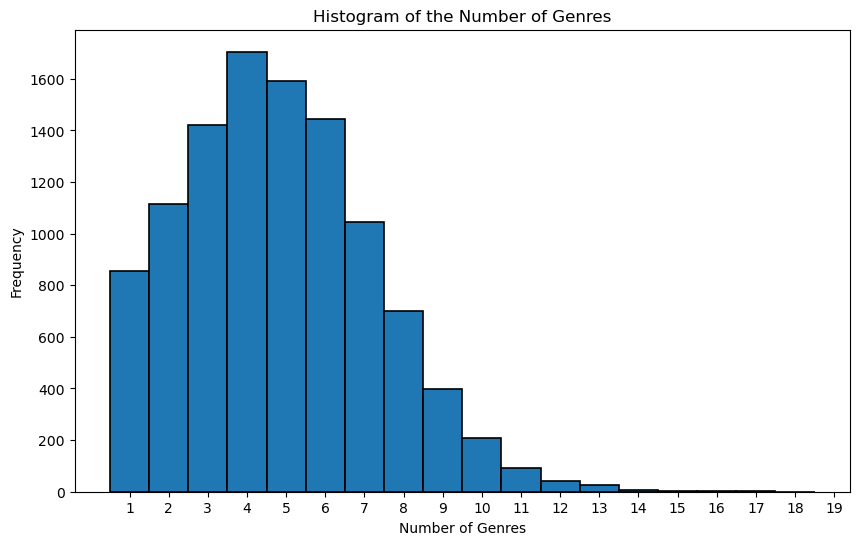

In [127]:
number_of_genres = gross_genre_release.drop_duplicates(subset='Wiki_ID')['genres'].dropna().apply(lambda x: len(x))
# histogram of the number of genres
plt.figure(figsize=(10, 6))
plt.hist(number_of_genres,bins = np.arange(1, 20, 1)-0.5, edgecolor = 'black', linewidth = 1.2)
plt.xlabel('Number of Genres')
plt.xticks(np.arange(1, 20, 1))
plt.ylabel('Frequency')
plt.title('Histogram of the Number of Genres')
plt.show()

We have a very low percentage of genre missing we can therefore have a good analysis about this metric. We don't have any missing values for the release date because it was used as a key when merging the IMdB dataset with the CMU datset

## Question 3 

In [94]:
movies_clean_country = movies_clean_genre.copy()
movies_clean_country['countries'] = movies_clean_country['countries'].apply(lambda x: list(ast.literal_eval(x).values()))
# This line is to make the empty list to be nan so the nan are uniform
movies_clean_country['countries'] = movies_clean_country['countries'].apply(lambda x: x if len(x) != 0 else np.nan)

In [95]:
gross_country = gross_genre_release.copy()
#merge gross and movies_clean_genre on wiki_ID
gross_country = gross_country.merge(movies_clean_country[['Wiki_ID', 'countries']], on = 'Wiki_ID', how = 'left')

In [96]:
# count the numers of nan in countries
missing_country_value = gross_country.drop_duplicates(subset='Wiki_ID')['countries'].isna().sum()/gross_country.drop_duplicates(subset='Wiki_ID')['countries'].shape[0]*100
print('The percentage of missing values in the countries column is {:.2f}%'.format(missing_country_value))

The percentage of missing values in the countries column is 1.70%


In [111]:
coprood_count = gross_country.dropna(subset='countries')
coprood_count = coprood_count.drop_duplicates(subset='Wiki_ID')[coprood_count['countries'].apply(lambda x: len(x)) > 1].shape[0]/gross_country.drop_duplicates(subset='Wiki_ID')['countries'].shape[0]*100

print('The number of movies that are co-produced by more than one country is {:.2f}%'.format(coprood_count))



The number of movies that are co-produced by more than one country is 24.98%


/tmp/ipykernel_8819/3641930436.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  coprood_count = coprood_count.drop_duplicates(subset='Wiki_ID')[coprood_count['countries'].apply(lambda x: len(x)) > 1].shape[0]/gross_country.drop_duplicates(subset='Wiki_ID')['countries'].shape[0]*100


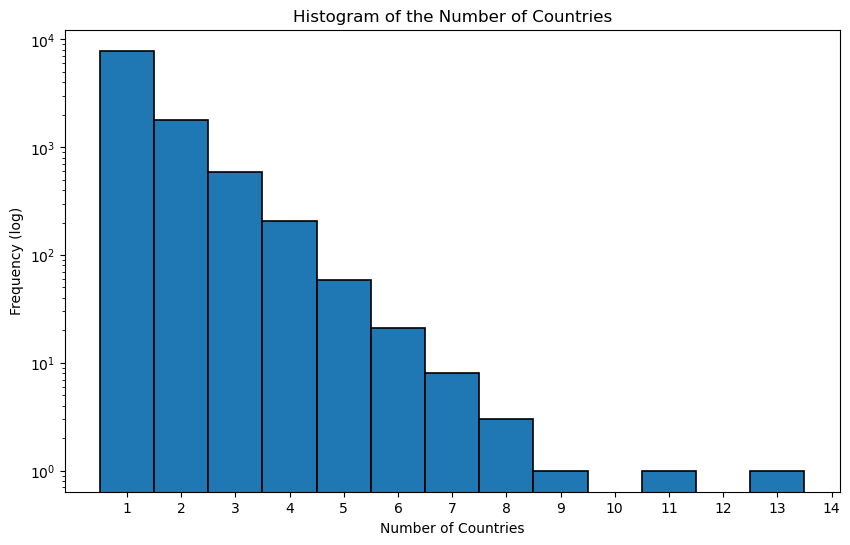

In [129]:
number_of_countries = gross_country.drop_duplicates(subset='Wiki_ID')['countries'].dropna().apply(lambda x: len(x))
# histogram of the number of production countries
plt.figure(figsize=(10, 6))
plt.hist(number_of_countries,bins = np.arange(1, 15, 1)-0.5, edgecolor = 'black', linewidth = 1.2)
plt.xlabel('Number of Countries')
plt.xticks(np.arange(1, 15, 1))
plt.yscale('log')
plt.ylabel('Frequency (log)')
plt.title('Histogram of the Number of Countries')
plt.show()

We have a very low percentage of countries missing we can therefore have a good analysis about this metric. And the level of co-production is relatively high so it will still make sense to do our analysis.

## Question 4

For the gender representation in the moviee. We decided to only use the values that were given for each of the movies, making the assumption that if the gender of an actor is not given the character was probably a small part. 

In [158]:
# go in the character dataset and find the percentage of gender F in each movie
character_gender = character.copy()

#count the number of "F" for each wiki_ID in character_gender
# groupby wiki_ID and count the number of "F" in each group
character_groupby = character_gender.groupby('Wiki_ID')
character_groupby_tot = character_groupby["actor_gender"].count()
character_groupby_F = character_groupby.apply(lambda x: (x['actor_gender'] == 'F').sum())
ratio_female_to_total = character_groupby_F / character_groupby_tot
print(ratio_female_to_total)



Wiki_ID
330         1.000000
3217        0.230769
3333        0.428571
3746        0.214286
3837        0.100000
              ...   
37373877    0.500000
37476824    0.400000
37478048    0.250000
37492363         NaN
37501922    0.500000
Length: 64330, dtype: float64


In [162]:
data = {
    'Wiki_ID': ratio_female_to_total.index,
    'Ratio_Female_to_Total': ratio_female_to_total.values
}

# Create DataFrame
df_ratio = pd.DataFrame(data)

# Reset the index to make it 1-dimensional
df_ratio.reset_index(drop=True, inplace=True)

In [163]:
movies_clean_gender = movies_clean_country.copy()
movies_clean_gender = movies_clean_gender.merge(df_ratio, on = 'Wiki_ID', how = 'left')
print(movies_clean_gender.head(10))

    Wiki_ID Freebase_ID                                               name  \
0    975900   /m/03vyhn                                     Ghosts of Mars   
1   3196793   /m/08yl5d  Getting Away with Murder: The JonBenét Ramsey ...   
2  28463795  /m/0crgdbh                                        Brun bitter   
3   9363483  /m/0285_cd                                   White Of The Eye   
4    261236   /m/01mrr1                                  A Woman in Flames   
5  13696889  /m/03cfc81                                      The Gangsters   
6  18998739  /m/04jcqvw                          The Sorcerer's Apprentice   
7  10408933  /m/02qc0j7                           Alexander's Ragtime Band   
8   9997961  /m/06_y2j7                                     Contigo y aquí   
9   2345652   /m/075f66                                   City of the Dead   

   release_date  box_office  runtime  \
0        2001.0  14010832.0     98.0   
1        2000.0         NaN     95.0   
2        1988.0      

In [99]:
# Analyzing Ethnicity Data
print(f"Total entries in character dataframe: {len(character)}")

# Check for missing values in 'actor_ethnicity'
missing_ethnicity = character['actor_ethnicity'].isna().sum()
print(f"Number of missing values in 'actor_ethnicity': {missing_ethnicity}")
print(f"Percentage of missing values in 'actor_ethnicity': {missing_ethnicity / len(character) * 100:.2f}%")

Total entries in character dataframe: 450669
Number of missing values in 'actor_ethnicity': 344611
Percentage of missing values in 'actor_ethnicity': 76.47%


In [100]:
#Filling Nan with 'Unknown' ethnicity
character_ethnicity = character_gender.copy()
character_ethnicity['actor_ethnicity'] = character_ethnicity['actor_ethnicity']

# Analyzing ethnicity distribution
ethnicity_distribution = character['actor_ethnicity'].value_counts(normalize=True) * 100
print(ethnicity_distribution)

actor_ethnicity
/m/0dryh9k    15.417036
/m/0x67        9.578721
/m/041rx       9.542892
/m/02w7gg      5.812857
/m/033tf_      3.636689
                ...    
/m/043_z22     0.000943
/m/03x_fq7     0.000943
/m/01hphz      0.000943
/m/033fjj      0.000943
/m/013y54      0.000943
Name: proportion, Length: 479, dtype: float64


We have the distribution of the ethnicities, but they are encoded as ids. Lets decode them :

In [101]:
# Load the CSV file into a DataFrame
ethnicity_labels_df = pd.read_csv('./dictionnaries/ethnicity_labels.csv')

# Convert the DataFrame to a dictionary
ethnicity_labels = dict(zip(ethnicity_labels_df['Freebase ID'], ethnicity_labels_df['Ethnicity Label']))

# Replace the codes in 'ethnicity_distribution' with their labels
ethnicity_distribution_labeled = ethnicity_distribution.rename(index=ethnicity_labels)

# Print the updated distribution
print(ethnicity_distribution_labeled)

actor_ethnicity
Indian person             15.417036
African Americans          9.578721
Jewish people              9.542892
English people             5.812857
Irish Americans            3.636689
                            ...    
/m/043_z22                 0.000943
Aboriginal Australians     0.000943
Indian diaspora            0.000943
Ho-Chunk                   0.000943
Han Chinese people         0.000943
Name: proportion, Length: 479, dtype: float64


We can see that some ethnicities aren't translated. Lets analyse them.

In [102]:
# Identifying untranslated ethnicity codes
untranslated_codes = set(character_ethnicity['actor_ethnicity']) - set(ethnicity_labels.keys())
untranslated_codes = {code for code in untranslated_codes if isinstance(code, str)}  # Ensure that NaNs are not included

# Counting the number of untranslated ethnicities
untranslated_counts = character_ethnicity['actor_ethnicity'].apply(lambda x: x if x in untranslated_codes else np.nan).value_counts()

character_ethnicity_df = character_ethnicity.copy()

# Find the most common untranslated ethnicity
if not untranslated_counts.empty:
    most_common_untranslated = untranslated_counts.idxmax()
    most_common_untranslated_count = untranslated_counts.max()
    print(f"Most common untranslated ethnicity: {most_common_untranslated} ({most_common_untranslated_count} occurrences)")

    print("Five most common untranslated ethnicities:")
    print(untranslated_counts.head(5))

    # # Replace untranslated ethnicities with NaN
    # character_ethnicity_df['actor_ethnicity'] = character_ethnicity_df['actor_ethnicity'].replace(untranslated_codes, np.nan)

    # # Recompute the ethnicity distribution
    # ethnicity_distribution = character_ethnicity_df['actor_ethnicity'].value_counts(normalize=True, dropna=True) * 100
    # ethnicity_distribution_labeled = ethnicity_distribution.rename(index=ethnicity_labels)
    # print(ethnicity_distribution_labeled)
else:
    print("No untranslated ethnicity codes found.")

Most common untranslated ethnicity: /m/044038p (1885 occurrences)
Five most common untranslated ethnicities:
actor_ethnicity
/m/044038p    1885
/m/02p1pl6     200
/m/04tvpv      197
/m/02p656s     121
/m/0283js_      81
Name: count, dtype: int64


There are 1885 actors with ethnicity '/m/044038p'. Lets see who they are.

In [103]:
# Filter for actors with the specified ethnicity code
actors_with_specific_ethnicity = character_ethnicity[character_ethnicity['actor_ethnicity'] == '/m/044038p']

# Select 10 actors from this group
sample_actors = actors_with_specific_ethnicity.sample(10)

# Print the selected actors
print(sample_actors[['actor_name', 'actor_ethnicity']])

                 actor_name actor_ethnicity
11141         Maury Chaykin      /m/044038p
16321         James Cameron      /m/044038p
276202   Deborah Kara Unger      /m/044038p
170069           Terry Chen      /m/044038p
205682          Kyle Schmid      /m/044038p
396517      Brennan Elliott      /m/044038p
196880        Paul Campbell      /m/044038p
825            J. R. Bourne      /m/044038p
335857  Christopher Plummer      /m/044038p
210758          Susan Hogan      /m/044038p


Those 10 actors are all canadians. We will call this ethnicity 'Canadians'.

In [130]:
# Define a function to replace unknown ethnicities
def replace_unknown_ethnicities(ethnicity):
    if ethnicity == '/m/044038p':
        return 'Canadians'
    elif not ethnicity in ethnicity_labels.keys():
        return 'Unknown'
    else:
        return ethnicity

# Apply the function to the actor_ethnicity column
character_ethnicity['actor_ethnicity'] = character_ethnicity['actor_ethnicity'].apply(replace_unknown_ethnicities)

# Optionally, you can print a few rows to verify the changes
print(character_ethnicity.head())

   Wiki_ID Freebase_ID release_date              character_name   actor_DOB  \
0   975900   /m/03vyhn   2001-08-24                    Akooshay  1958-08-26   
1   975900   /m/03vyhn   2001-08-24  Lieutenant Melanie Ballard  1974-08-15   
2   975900   /m/03vyhn   2001-08-24         Desolation Williams  1969-06-15   
3   975900   /m/03vyhn   2001-08-24          Sgt Jericho Butler  1967-09-12   
4   975900   /m/03vyhn   2001-08-24             Bashira Kincaid  1977-09-25   

  actor_gender  actor_height actor_ethnicity          actor_name  actor_age  
0            F         1.620         Unknown      Wanda De Jesus       42.0  
1            F         1.780         Unknown  Natasha Henstridge       27.0  
2            M         1.727         /m/0x67            Ice Cube       32.0  
3            M         1.750         Unknown       Jason Statham       33.0  
4            F         1.650         Unknown         Clea DuVall       23.0  


In [137]:
# Replace 'Unknown' with np.nan in the actor_ethnicity column
character_ethnicity['actor_ethnicity'] = character_ethnicity['actor_ethnicity'].replace('Unknown', np.nan)

# Optionally, print a few rows to verify the changes
print(character_ethnicity.head())

   Wiki_ID Freebase_ID release_date              character_name   actor_DOB  \
0   975900   /m/03vyhn   2001-08-24                    Akooshay  1958-08-26   
1   975900   /m/03vyhn   2001-08-24  Lieutenant Melanie Ballard  1974-08-15   
2   975900   /m/03vyhn   2001-08-24         Desolation Williams  1969-06-15   
3   975900   /m/03vyhn   2001-08-24          Sgt Jericho Butler  1967-09-12   
4   975900   /m/03vyhn   2001-08-24             Bashira Kincaid  1977-09-25   

  actor_gender  actor_height actor_ethnicity          actor_name  actor_age  
0            F         1.620             NaN      Wanda De Jesus       42.0  
1            F         1.780             NaN  Natasha Henstridge       27.0  
2            M         1.727         /m/0x67            Ice Cube       32.0  
3            M         1.750             NaN       Jason Statham       33.0  
4            F         1.650             NaN         Clea DuVall       23.0  


In [105]:
def extract_languages(lang_str):
    if pd.isna(lang_str):
        return ['Unknown']
    try:
        # Parse the string as a dictionary
        lang_dict = ast.literal_eval(lang_str)
        # Extract the language names and remove 'Language' from the end
        languages = [lang.split(' Language')[0] for lang in lang_dict.values()]

        return languages
    except ValueError:
        # Handle cases where lang_str cannot be parsed
        return ['Unknown']

movies_clean_languages = movies_clean_country.copy()
movies_clean_languages['languages'] = movies_clean_languages['languages'].apply(extract_languages)

# Counting languages
language_counts = pd.Series([lang for sublist in movies_clean_languages['languages'] for lang in sublist]).value_counts()
print(language_counts)

English                                 40891
Hindi                                    3744
Spanish                                  3673
French                                   3422
Silent film                              3183
                                        ...  
Southwestern Mandarin                       1
Australian Aboriginal Pidgin English        1
Krio                                        1
Pawnee                                      1
Kuna language                               1
Name: count, Length: 205, dtype: int64


In [106]:
# Count the number of movies with more than one language
multilingual_movies = movies_clean_languages['languages'].apply(lambda x: len(x) > 1)

print(f"Number of multilingual movies: {multilingual_movies.sum()} over {len(multilingual_movies)} movies.")
print(movies_clean_languages['languages'][multilingual_movies].head())

Number of multilingual movies: 9807 over 81741 movies.
5     [Silent film, English]
48    [Silent film, English]
49      [Afrikaans, English]
51    [Silent film, English]
52    [Silent film, English]
Name: languages, dtype: object


In [107]:
# Creating a new dataframe for multilingual movies for language combination analysis
multilingual_combinations_df = movies_clean_languages.copy()
multilingual_combinations_df = multilingual_combinations_df[multilingual_combinations_df['languages'].apply(lambda x: len(x) > 1 and 'Unknown' not in x)]

# Create a distinct identifier for each multilingual language combination
multilingual_combinations_df['multilingual_combination'] = multilingual_combinations_df['languages'].apply(lambda x: '-'.join(sorted(x)))

# Count the occurrences of each multilingual language combination
multilingual_combination_counts = multilingual_combinations_df['multilingual_combination'].value_counts()
print("Most common multilingual language combinations:")
print(multilingual_combination_counts.head())  # Adjust the number of combinations to display as needed


Most common multilingual language combinations:
multilingual_combination
English-Silent film    2297
English-French          522
English-Spanish         506
English-Italian         278
English-German          264
Name: count, dtype: int64


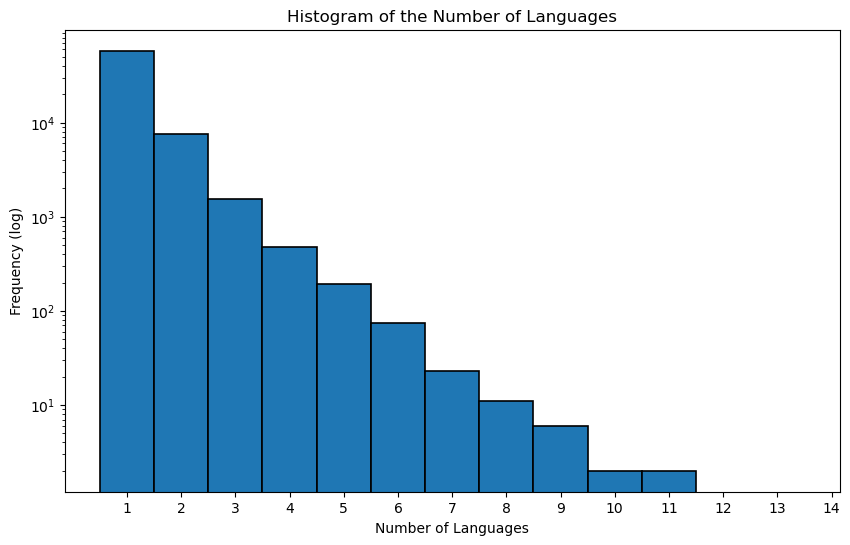

In [124]:
number_of_languages = movies_clean_languages.drop_duplicates(subset='Wiki_ID')['languages'].dropna().apply(lambda x: len(x))
# histogram of the number of genres
plt.figure(figsize=(10, 6))
plt.hist(number_of_languages,bins = np.arange(1, 15, 1)-0.5, edgecolor = 'black', linewidth = 1.2)
plt.xlabel('Number of Languages')
plt.xticks(np.arange(1, 15, 1))
plt.ylabel('Frequency (log)')
plt.yscale('log')
plt.title('Histogram of the Number of Languages')
plt.show()